In [1]:
import os
from pathlib import Path
import re
import subprocess
from math import log10, floor
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from copy import deepcopy
import pandas as pd
import itertools
from pptx import Presentation
from pptx.util import Inches

from pymatgen.ext.matproj import MPRester, MPRestError
from monty.serialization import loadfn, dumpfn
from pymatgen import Structure, Composition
from pymatgen.analysis.reaction_calculator import ComputedEntry, ComputedReaction
from pymatgen.analysis.local_env import CrystalNN
from pymatgen.analysis.defects.utils import ChargeDensityAnalyzer
from pymatgen.util.plotting import pretty_plot, periodic_table_heatmap
from pymatgen.command_line.bader_caller import BaderAnalysis
from pymatgen.core import periodic_table
from pymatgen.core.sites import Site, PeriodicSite
from pymatgen.core.bonds import CovalentBond, bond_lengths
from pymatgen.io.vasp.outputs import Elfcar, VolumetricData, Chgcar

from slicing_helper import UnitCellData, generate_3d, take_slice, plot_slice, plot_3d, contour_map

from scipy.stats import linregress, skew, describe
from scipy.interpolate import RegularGridInterpolator
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error

In [2]:
PROJECT = 'SCAN project'

workdir = Path(re.sub("(?<={})[\w\W]*".format(PROJECT), "", '/mnt/c/Users/Ayush/Desktop/elf-analysis/'))
os.chdir(workdir)

data_dir = workdir / 'SCAN_bader_data'
output_dir = workdir / 'vasp_files'

In [3]:
print(workdir)
print(data_dir)
print(output_dir)

/mnt/c/Users/Ayush/Desktop/elf-analysis
/mnt/c/Users/Ayush/Desktop/elf-analysis/SCAN_bader_data
/mnt/c/Users/Ayush/Desktop/elf-analysis/vasp_files


In [4]:
class Datapoint:
    
    def __init__(self, label: str, attributes: dict = {}):
        self.label = label 
        self.attributes = attributes
        
    def has_attr(self, attr: str):
        return attr in self.attributes.keys()
    
    def get_attr(self, attr: str):
        assert self.has_attr(attr), 'Element \'{0}\' does not have attribute \'{1}\''.format(self.label, attr)
        return self.attributes[attr]
    
    @property
    def attribute_list(self):
        return list(self.attributes.keys())
    
    def add_attr(self, attrs: dict):
        self.attributes.update(attrs)
        
    
class Collection:
    
    def __init__(self, datapoints: list = []):
        self.datapoints = datapoints
        
    @property
    def labels(self):
        return [dp.label for dp in self.datapoints]
    
    def add_datapoint(self, datapoint: Datapoint):
        self.datapoints.append(datapoint)
        
    def add_attr(self, label: str, attr: dict):
        dp = self.get_datapoint(label)
        dp.add_attr(attr)
        
    def has_datapoint(self, label: str):
        return label in self.labels
        
    def get_datapoint(self, label: str):
        assert self.has_datapoint(label), 'This collection doesn\'t have a datapoint with label \'{}\''.format(label)
        return self.datapoints[self.labels.index(label)]
    
    def by_attr(self, attr: str):
        assert all([dp.has_attr(attr) for dp in self.datapoints]), 'Not all datapoints in collection have attribute \'{}\''.format(attr)
        return [dp.get_attr(attr) for dp in self.datapoints]

In [5]:
a = Datapoint('a', {'weight':5, 'height':2})
b = Datapoint('b', {'weight':7, 'height':1})
c = Datapoint('c', {'weight':3, 'height':0.1})
collection = Collection([a, b, c])

In [6]:
collection.by_attr('height')

[2, 1, 0.1]

In [7]:
def run_bader(printouts=True): 
    compound_list = []
    elfcar_dict = {}
    for d1 in data_dir.iterdir():
        os.chdir(d1)
        
        formula = str(os.getcwd()).replace(str(data_dir) + '/', '')
        if printouts:
            print('---------------------------------------------------------------')
            print(formula)
        compound_list.append(formula)
        
        elfcar_dict[formula] = Elfcar.from_file('ELFCAR')
        
        if not os.path.isfile('CHGREF'):
            aeccar0, aeccar2 = Chgcar.from_file('AECCAR0'), Chgcar.from_file('AECCAR2')
            chgref = aeccar0 + aeccar2
            chgref.write_file('CHGREF')
            if printounts:
                print('\tCHGREF written')
        elif printouts:
            print('\tCHGREF already exists')
        
        if not os.path.isfile('ACF.dat'):
            subprocess.run(['bader', '-p', 'atom_index', 'CHGCAR', '-ref', 'CHGREF'])
            if printouts:
                print('\tBADER complete')
        elif printouts:
            print('\tBADER already ran')

    os.chdir(workdir)
    return compound_list, elfcar_dict

In [8]:
compounds, elfcar_dict = run_bader(printouts=False)

In [9]:
print(compounds)
elfcar_dict

['AgO', 'AuCl3', 'BaO2', 'CaO', 'CdO', 'CsCl', 'CsO2', 'CuO', 'FeCl3', 'GaCl3', 'HgO', 'InCl3', 'IrCl3', 'IrO2', 'KCl', 'MgO', 'NaCl', 'RbCl', 'RhCl3', 'SnO', 'SrO', 'SrO2', 'ZnO']


{'AgO': <pymatgen.io.vasp.outputs.Elfcar at 0x7fb6504bfc10>,
 'AuCl3': <pymatgen.io.vasp.outputs.Elfcar at 0x7fb6504bfd30>,
 'BaO2': <pymatgen.io.vasp.outputs.Elfcar at 0x7fb6504b5d00>,
 'CaO': <pymatgen.io.vasp.outputs.Elfcar at 0x7fb6504b5dc0>,
 'CdO': <pymatgen.io.vasp.outputs.Elfcar at 0x7fb650452c10>,
 'CsCl': <pymatgen.io.vasp.outputs.Elfcar at 0x7fb62371ffa0>,
 'CsO2': <pymatgen.io.vasp.outputs.Elfcar at 0x7fb62371fbb0>,
 'CuO': <pymatgen.io.vasp.outputs.Elfcar at 0x7fb650452c70>,
 'FeCl3': <pymatgen.io.vasp.outputs.Elfcar at 0x7fb650452fa0>,
 'GaCl3': <pymatgen.io.vasp.outputs.Elfcar at 0x7fb650452d90>,
 'HgO': <pymatgen.io.vasp.outputs.Elfcar at 0x7fb6236b9100>,
 'InCl3': <pymatgen.io.vasp.outputs.Elfcar at 0x7fb650445580>,
 'IrCl3': <pymatgen.io.vasp.outputs.Elfcar at 0x7fb6504bfcd0>,
 'IrO2': <pymatgen.io.vasp.outputs.Elfcar at 0x7fb650452ee0>,
 'KCl': <pymatgen.io.vasp.outputs.Elfcar at 0x7fb650452fd0>,
 'MgO': <pymatgen.io.vasp.outputs.Elfcar at 0x7fb650452b50>,
 'NaCl': <

In [10]:
def retrieve_index_masks():
    masks = {}
    for d1 in data_dir.iterdir():
        os.chdir(d1)
        formula = str(os.getcwd()).replace(str(data_dir) + '/', '')
        masks[formula] = Chgcar.from_file('AtIndex.dat')
    os.chdir(workdir)
    return masks    

In [11]:
index_masks = retrieve_index_masks()
index_masks

{'AgO': <pymatgen.io.vasp.outputs.Chgcar at 0x7fb62371faf0>,
 'AuCl3': <pymatgen.io.vasp.outputs.Chgcar at 0x7fb62371f8b0>,
 'BaO2': <pymatgen.io.vasp.outputs.Chgcar at 0x7fb62371fa00>,
 'CaO': <pymatgen.io.vasp.outputs.Chgcar at 0x7fb62366fac0>,
 'CdO': <pymatgen.io.vasp.outputs.Chgcar at 0x7fb62366fee0>,
 'CsCl': <pymatgen.io.vasp.outputs.Chgcar at 0x7fb62366ff40>,
 'CsO2': <pymatgen.io.vasp.outputs.Chgcar at 0x7fb62366f250>,
 'CuO': <pymatgen.io.vasp.outputs.Chgcar at 0x7fb62366fe50>,
 'FeCl3': <pymatgen.io.vasp.outputs.Chgcar at 0x7fb623677b50>,
 'GaCl3': <pymatgen.io.vasp.outputs.Chgcar at 0x7fb623677790>,
 'HgO': <pymatgen.io.vasp.outputs.Chgcar at 0x7fb623677a00>,
 'InCl3': <pymatgen.io.vasp.outputs.Chgcar at 0x7fb623677c10>,
 'IrCl3': <pymatgen.io.vasp.outputs.Chgcar at 0x7fb623673dc0>,
 'IrO2': <pymatgen.io.vasp.outputs.Chgcar at 0x7fb6236732e0>,
 'KCl': <pymatgen.io.vasp.outputs.Chgcar at 0x7fb6236736a0>,
 'MgO': <pymatgen.io.vasp.outputs.Chgcar at 0x7fb62367b550>,
 'NaCl': <

In [12]:
print(compounds)

['AgO', 'AuCl3', 'BaO2', 'CaO', 'CdO', 'CsCl', 'CsO2', 'CuO', 'FeCl3', 'GaCl3', 'HgO', 'InCl3', 'IrCl3', 'IrO2', 'KCl', 'MgO', 'NaCl', 'RbCl', 'RhCl3', 'SnO', 'SrO', 'SrO2', 'ZnO']


In [13]:
for f in ['RhCl3']:
    ucb = generate_3d(f, index_masks)
    plot_slice(ucb, 'x', 1, f)

In [14]:
os.chdir(workdir)
error_data = pd.read_json(loadfn('lab_data/error_data.json'))
error_dict = {}
for i, j in error_data.iterrows():
    error_dict[j.Formula] = j.Error

In [15]:
data = Collection()

for f in compounds:
    dp = Datapoint(label=f, 
                   attributes = {'error':error_dict[f], 
                                 'num_bader_wells':int(max(index_masks[f].data['total'].flatten()))})
    data.add_datapoint(dp)

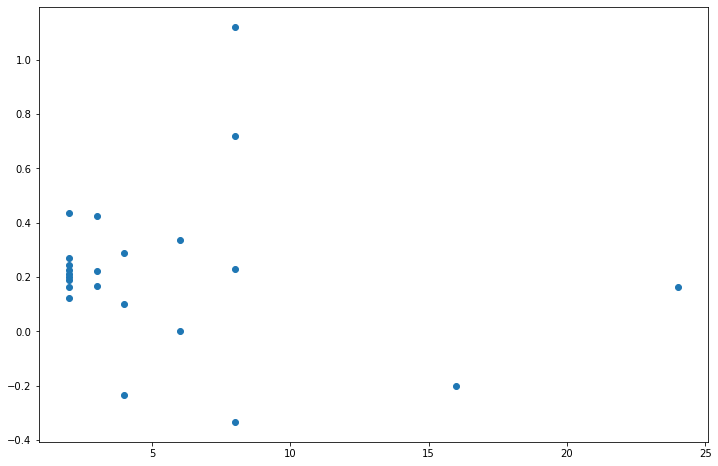

In [16]:
plt.scatter(data.by_attr('num_bader_wells'), data.by_attr('error'))

In [17]:
def create_mask(index_mask, index):
    dt = index_mask.data['total']
    shape = dt.shape
    flat = dt.flatten()
    for i in range(len(flat)):
        flat[i] = 1 if int(flat[i]) == index else 0
    mask = flat.reshape(shape)
    return mask

In [18]:
def apply_mask(elfcar, mask):
    dt = elfcar.data['total']
    s1, s2 = dt.shape, mask.shape
    factor = s2[0] / s1[0]
    flat, mf = dt.flatten(), mask.flatten()
    for i in range(len(flat)):
        flat[i] = flat[i] * mf[int(i*factor)]
    masked = flat.reshape(s1)
    return masked

In [19]:
def filter_zeros(mask):
    mf = mask.flatten()
    return [n for n in mf if n != 0]

In [20]:
for f in compounds:
    s1, s2 = index_masks[f].data['total'].shape, elfcar_dict[f].data['total'].shape
    print(s1[0] / s2[0], s1[1] / s2[1], s1[2] / s2[2])

2.0 2.0 2.0
2.0 2.0 2.0
2.0 2.0 2.0
2.0 2.0 2.0
2.0 2.0 2.0
2.0 2.0 2.0
2.0 2.0 2.0
2.0 2.0 2.0
2.0 2.0 2.0
2.0 2.0 2.0
2.0 2.0 2.0
2.0 2.0 2.0
2.0 2.0 2.0
2.0 2.0 2.0
2.0 2.0 2.0
2.0 2.0 2.0
2.0 2.0 2.0
2.0 2.0 2.0
2.0 2.0 2.0
2.0 2.0 2.0
2.0 2.0 2.0
2.0 2.0 2.0
2.0 2.0 2.0


In [21]:
def create_mask_dict():
    elf, alpha = {}, {}
    for f in compounds:
        el, al = elfcar_dict[f], elfcar_dict[f].get_alpha()
        masked_e, masked_a = [], []
        for i in range(1, data.get_datapoint(f).get_attr('num_bader_wells') + 1):
            mask = create_mask(index_masks[f], i)
            masked_e.append(apply_mask(el, mask))
            masked_a.append(apply_mask(al, mask))
        elf[f], alpha[f] = masked_e, masked_a
    return elf, alpha

In [22]:
masked_elf, masked_alpha = create_mask_dict()

In [23]:
def plot_histogram(f, mode='elf'):
    if mode == 'elf':
        data = masked_elf[f]
        disp = 'ELF'
    elif mode == 'alpha':
        data = masked_alpha[f]
        disp = 'α'
        
    processed = []
    for dat in data:
        processed.append([dp for dp in dat.flatten() if dp != 0.0])
    
        
    nbins = 100
    plt.hist(processed, 
             nbins, 
             histtype='bar', 
             stacked=True,
             label=['Bader Well {}'.format(i + 1) for i in range(len(dat))],
    )
    #plt.legend(loc="upper right")
    if mode == 'alpha':
        plt.yscale('log')
    
    plt.title('Distribution of {0} Values Across Bader Wells for {1}'.format(disp, f), fontsize=20)
    plt.xlabel('{} Value'.format(disp), fontsize=16)
    plt.ylabel('Count', fontsize=16)

    plt.show()

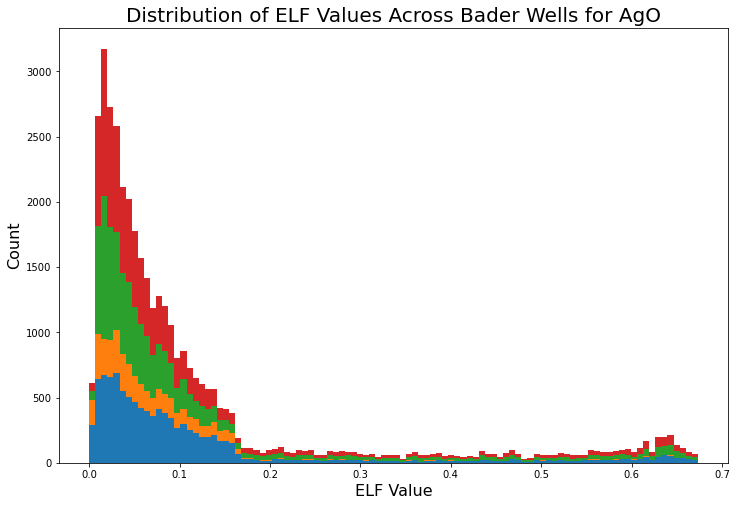

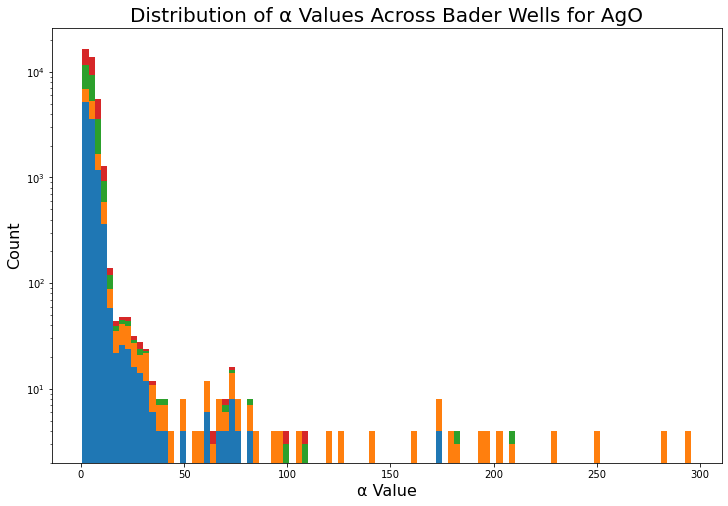

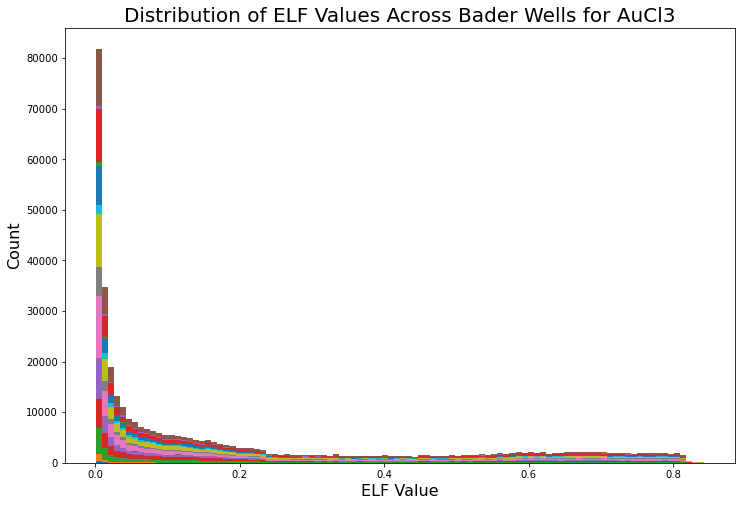

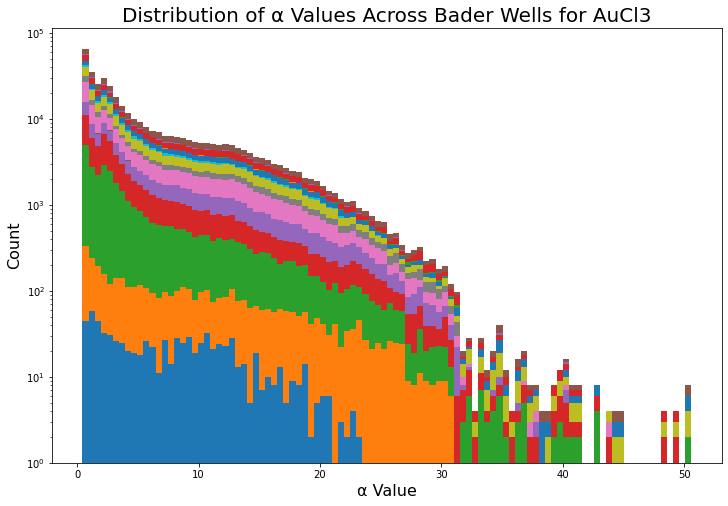

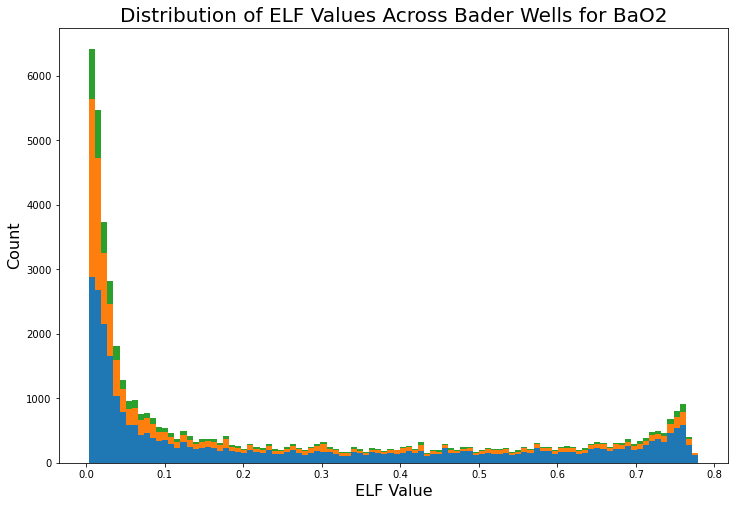

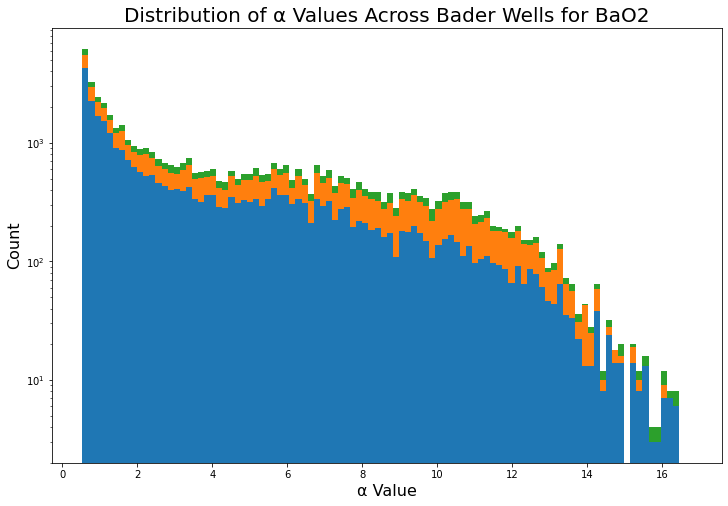

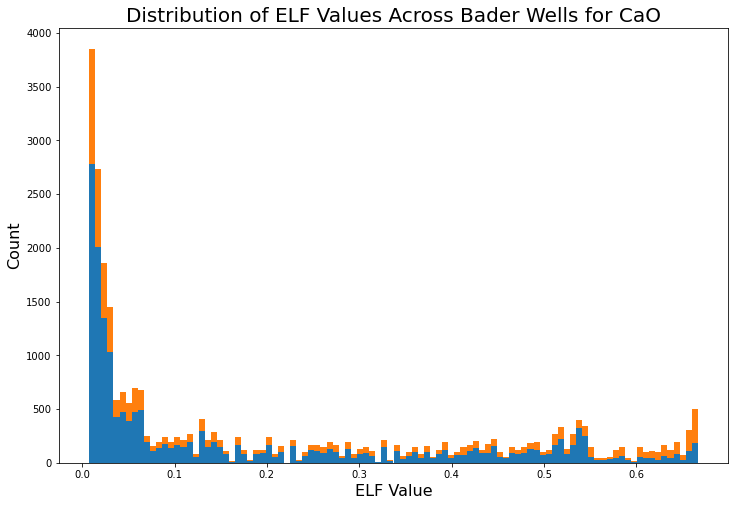

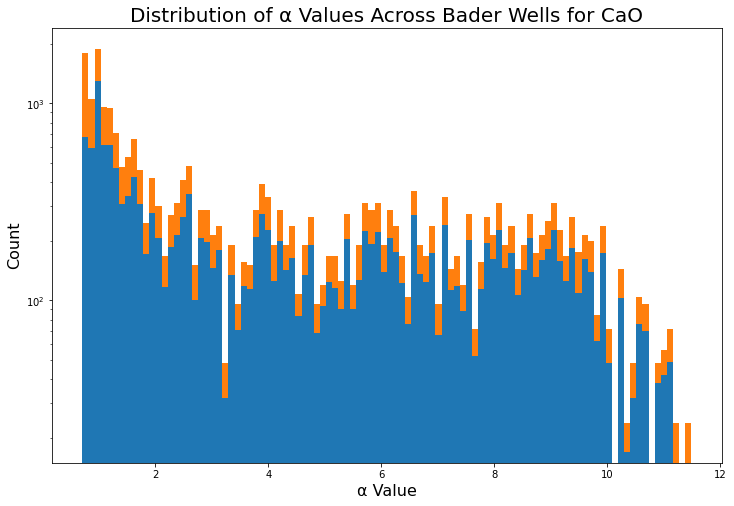

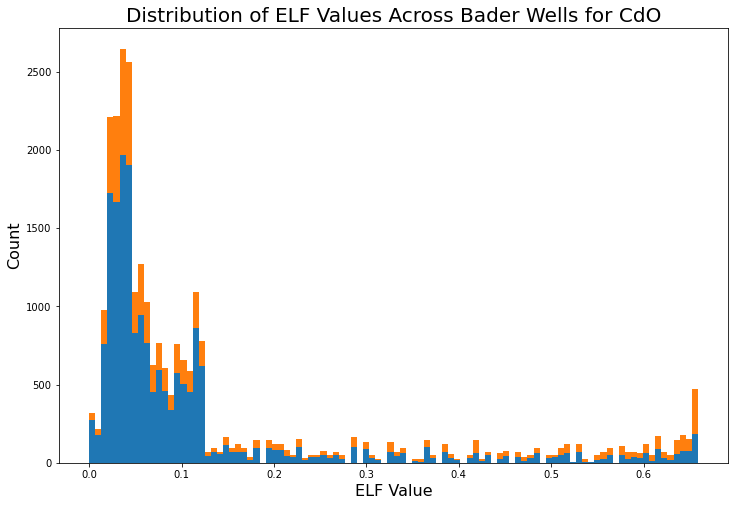

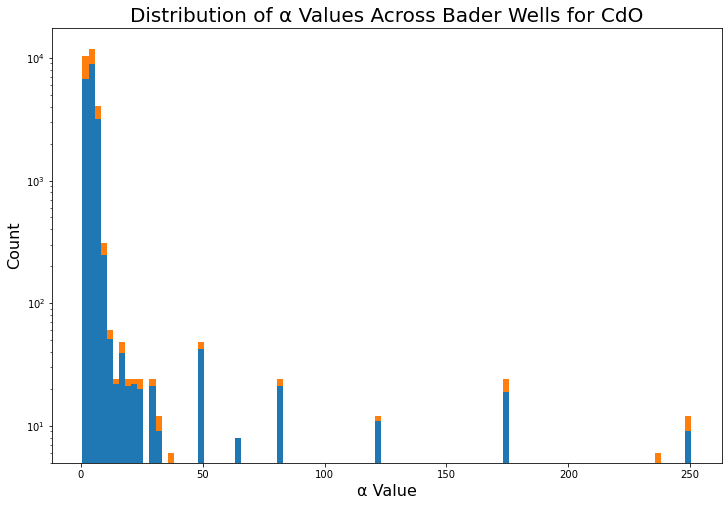

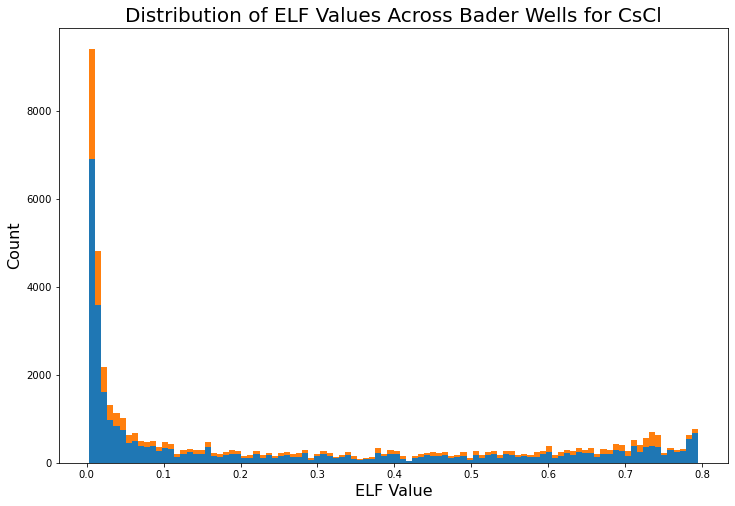

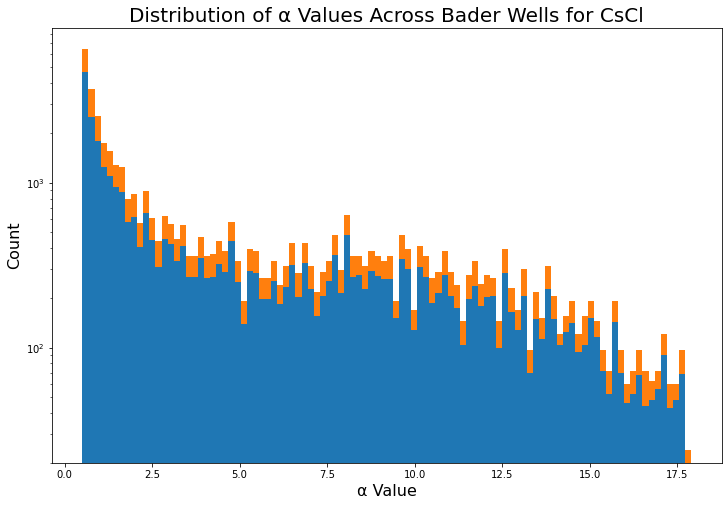

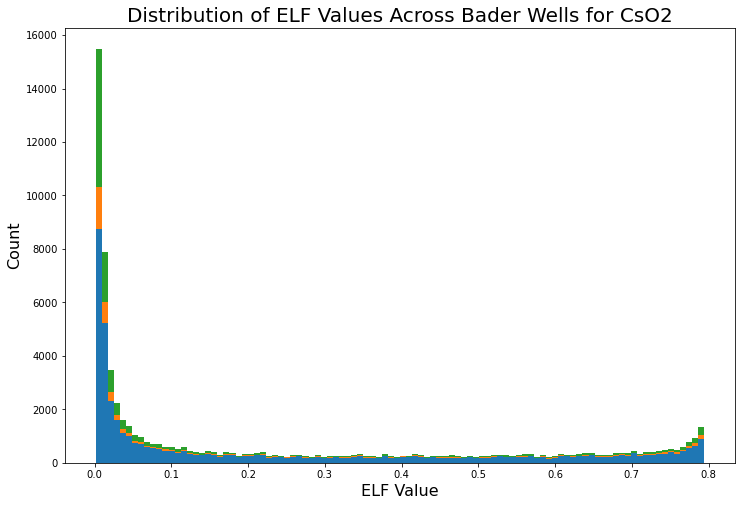

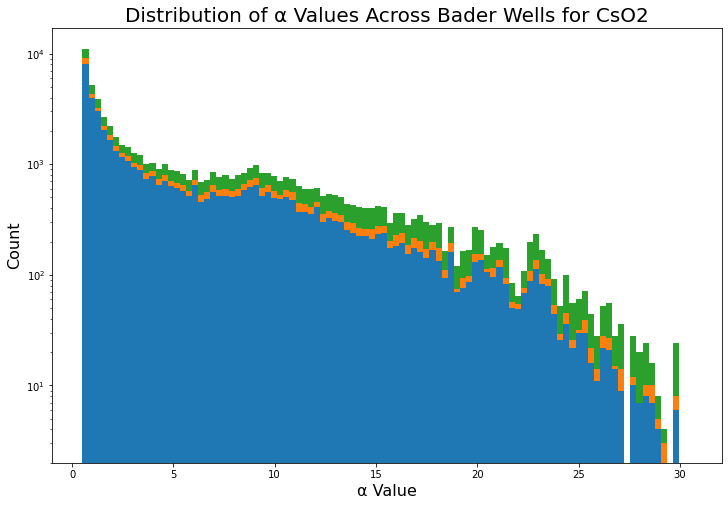

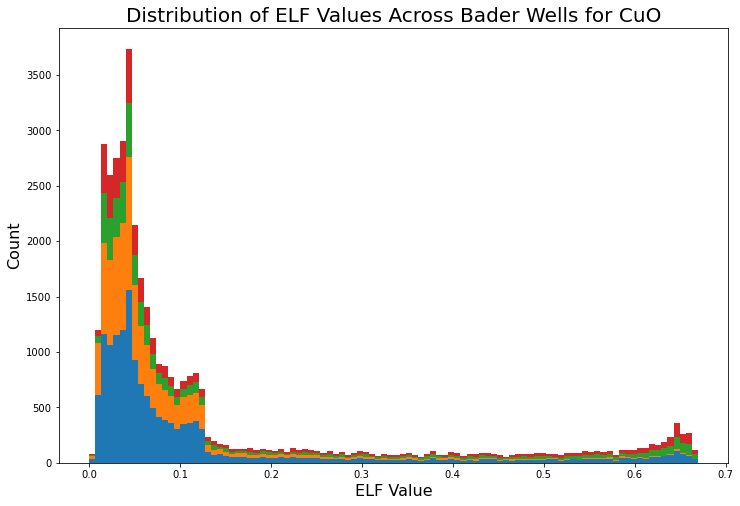

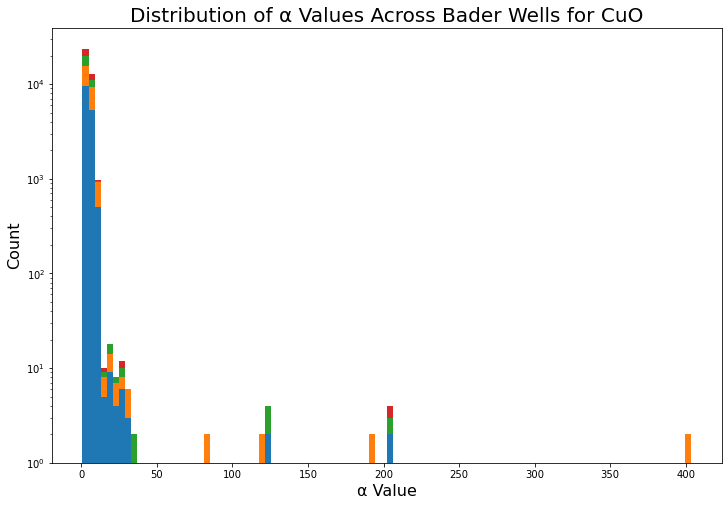

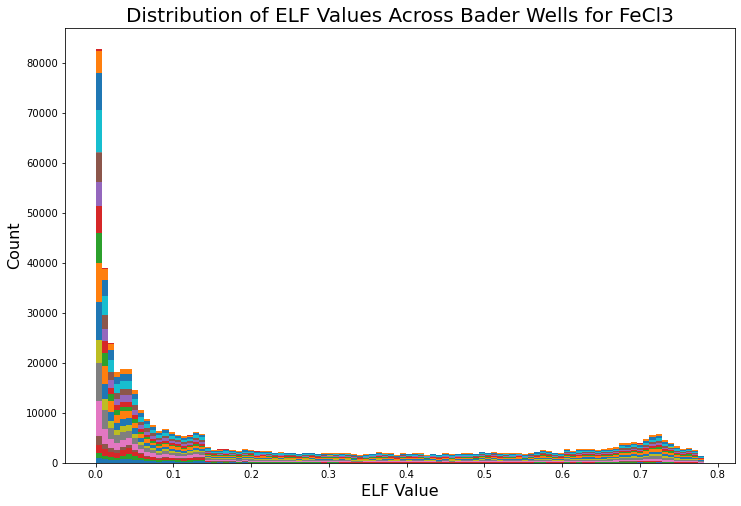

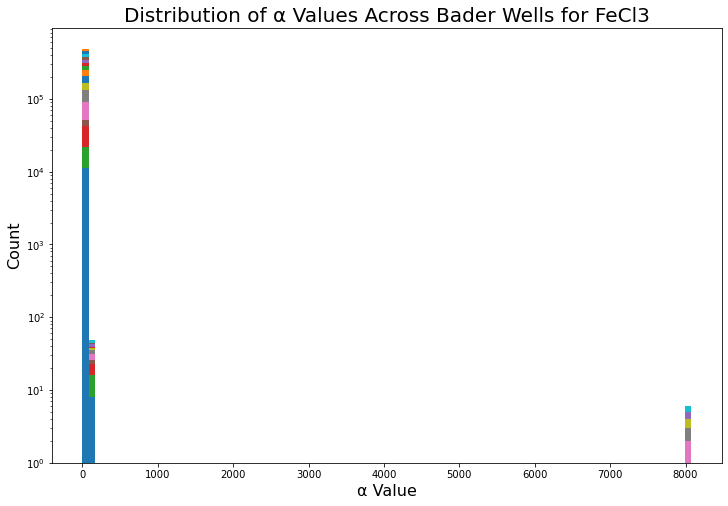

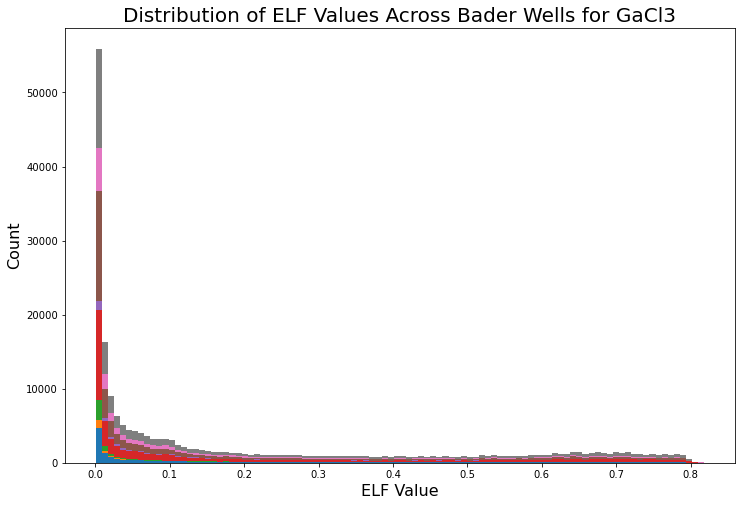

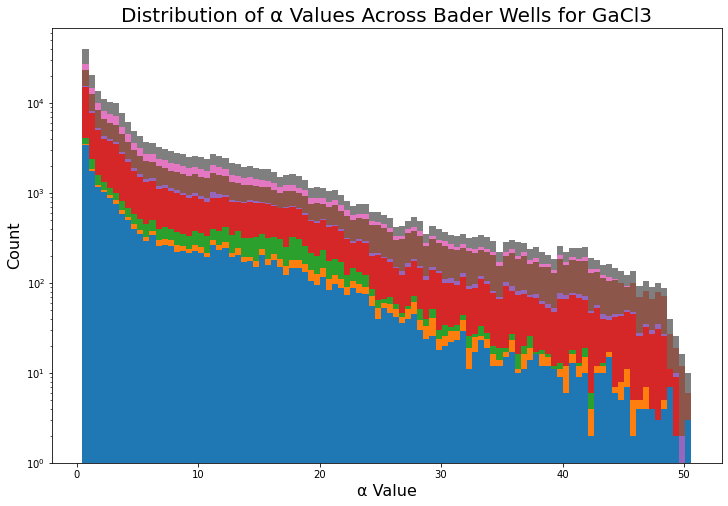

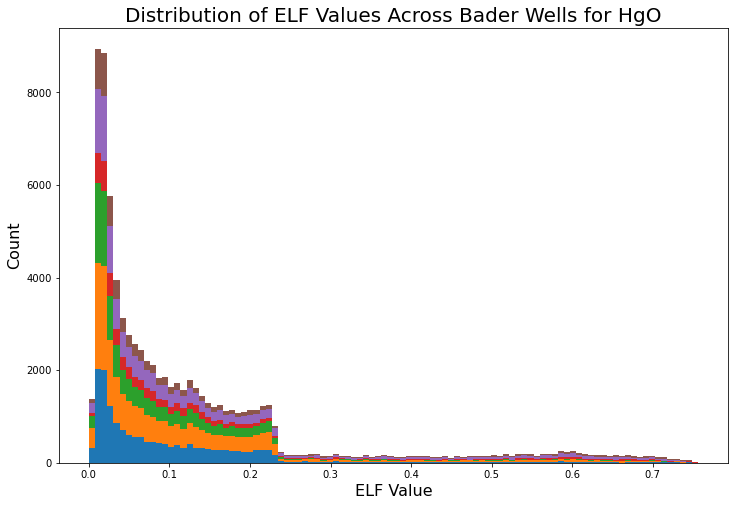

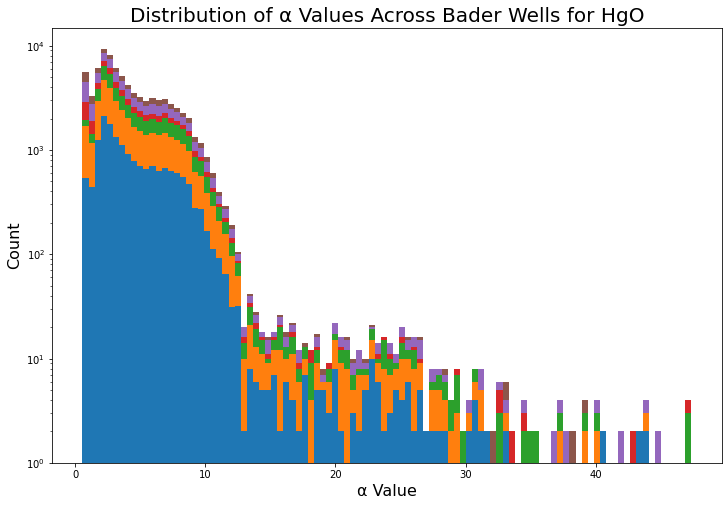

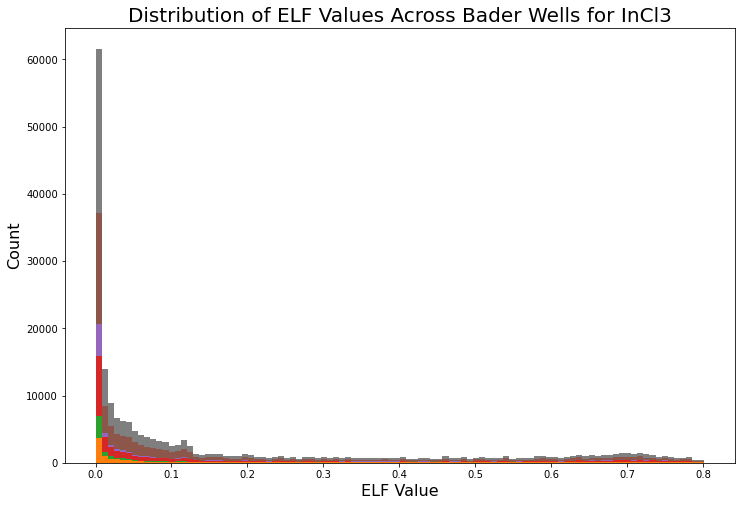

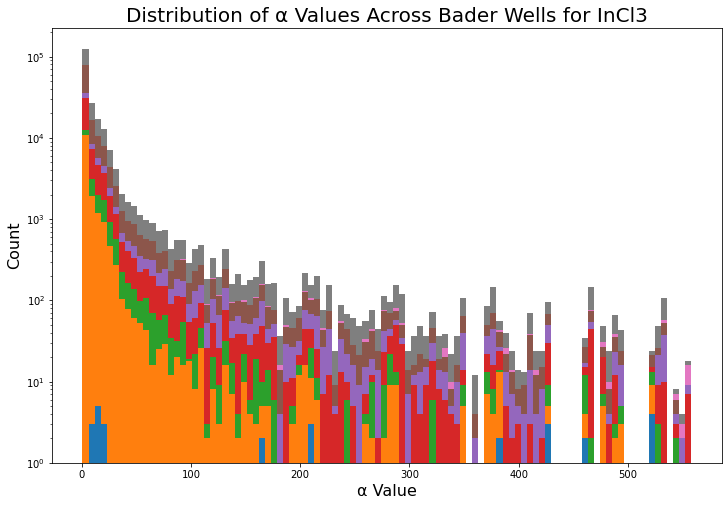

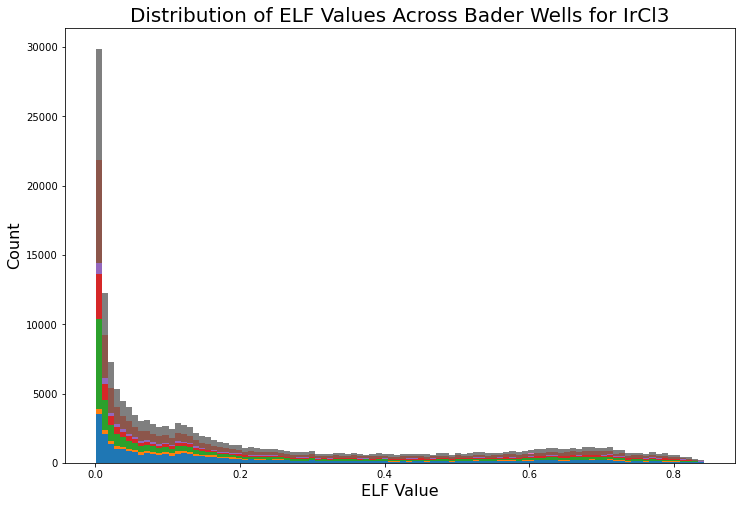

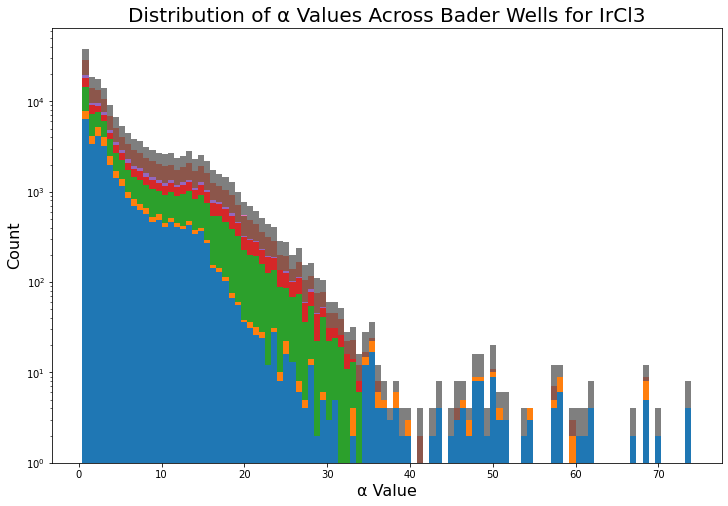

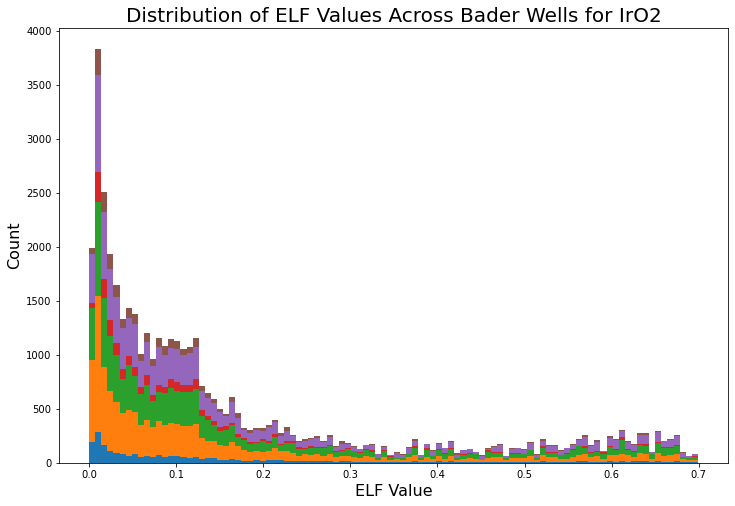

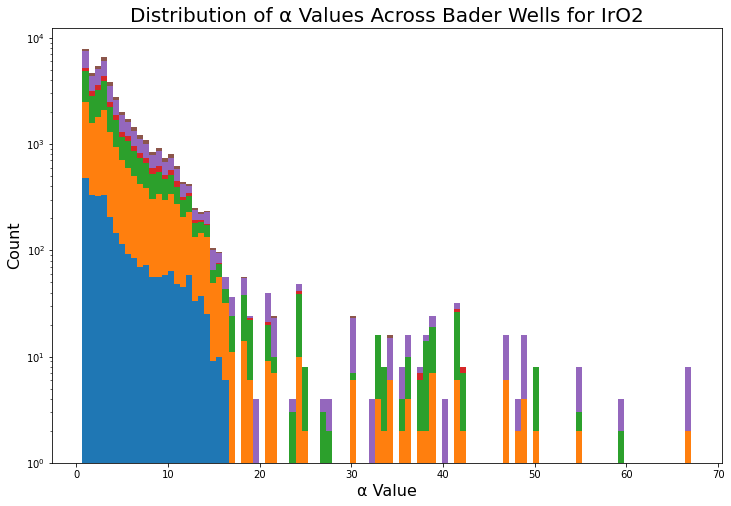

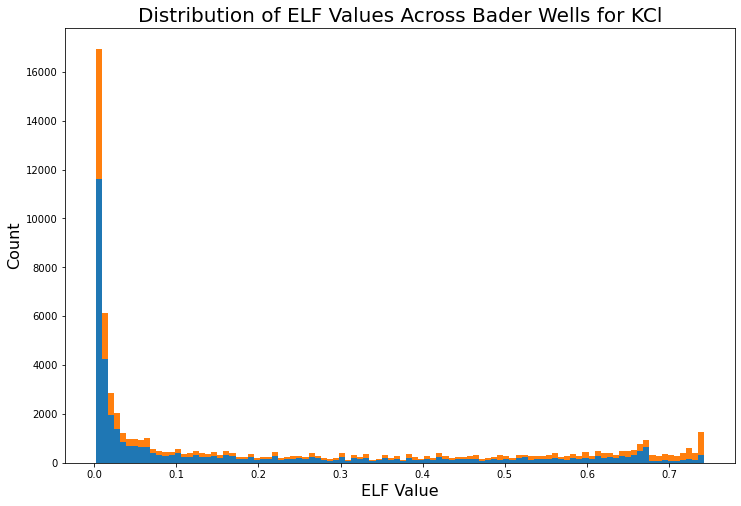

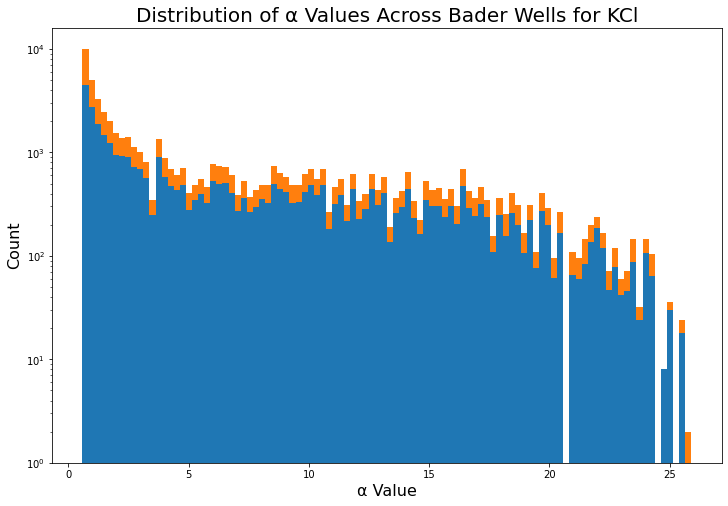

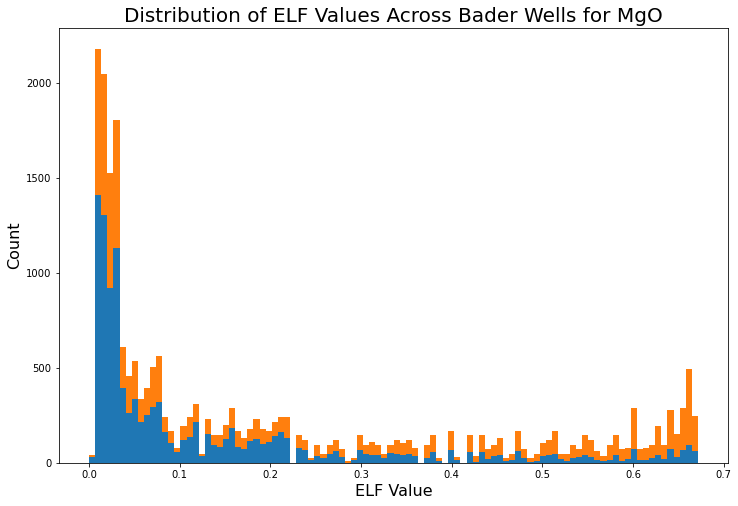

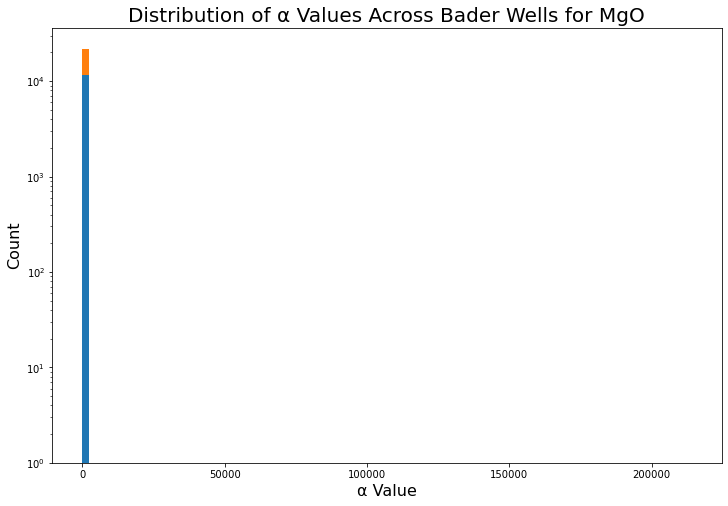

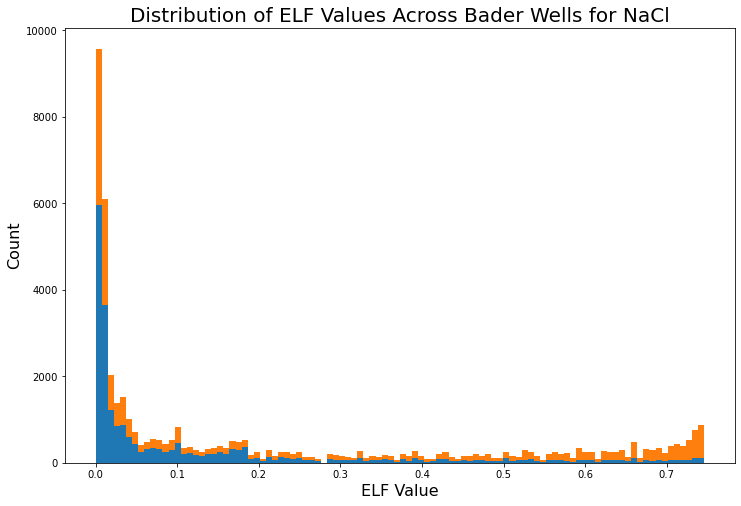

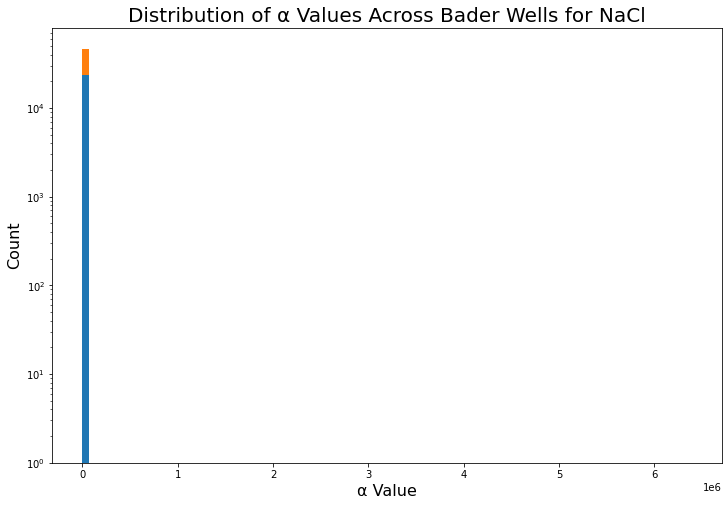

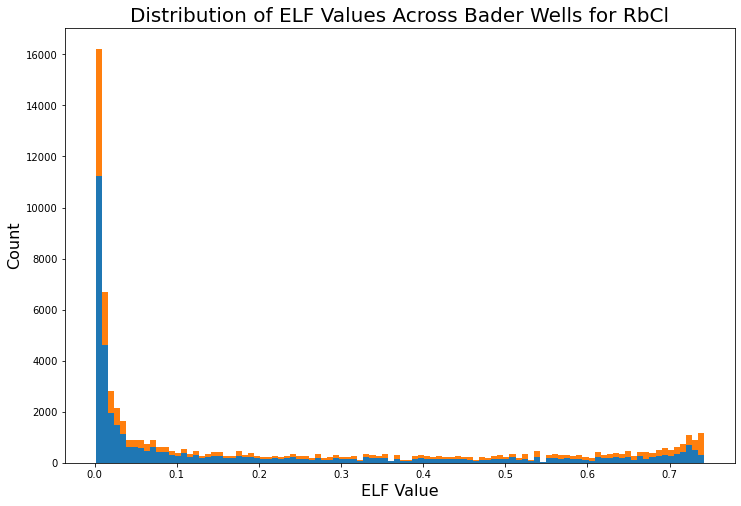

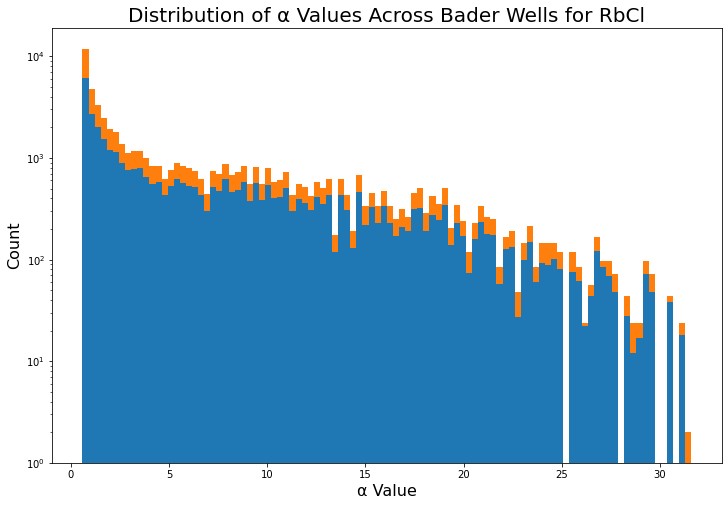

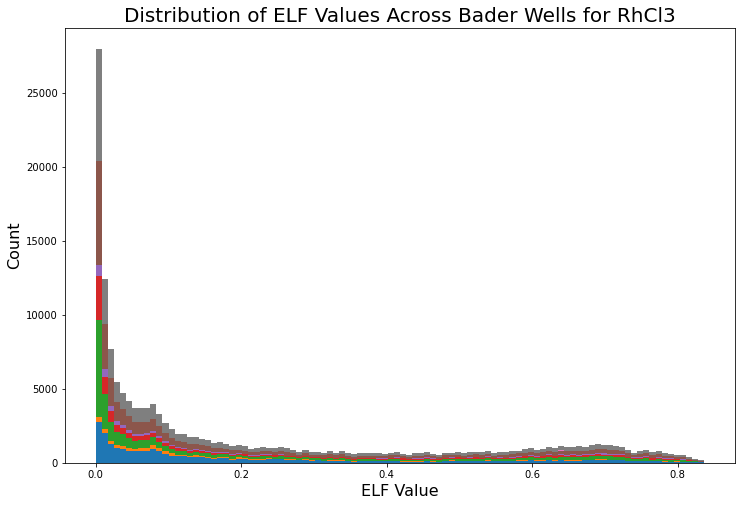

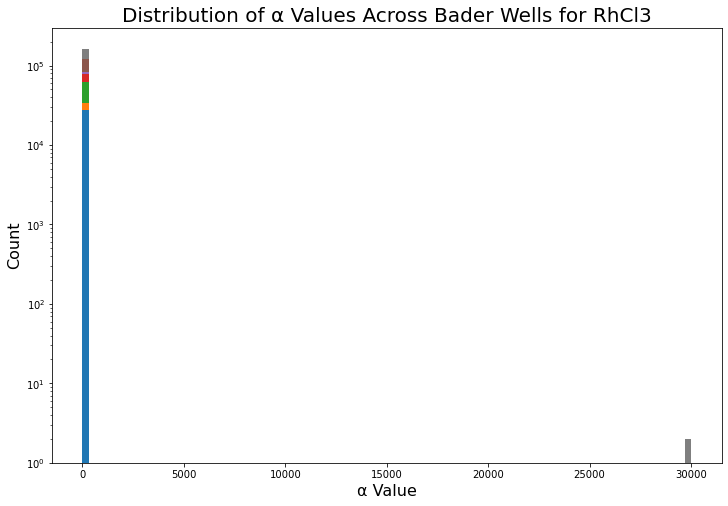

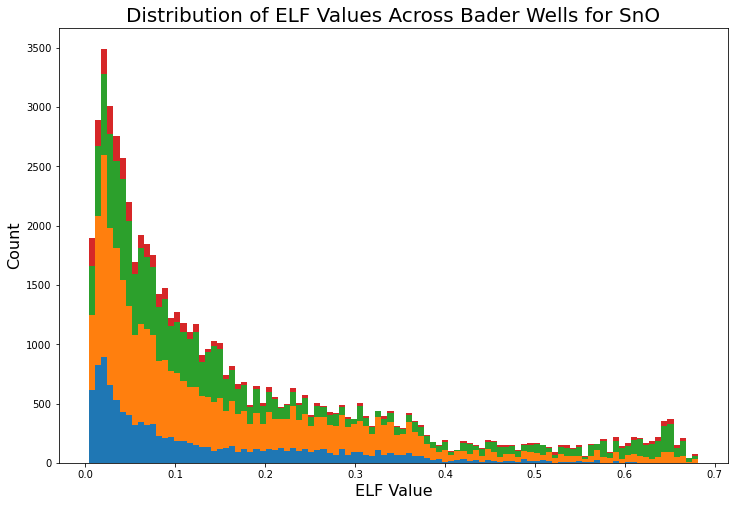

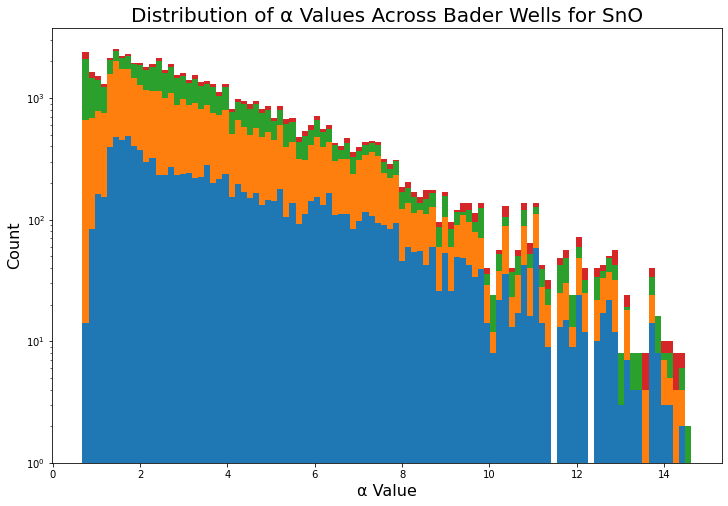

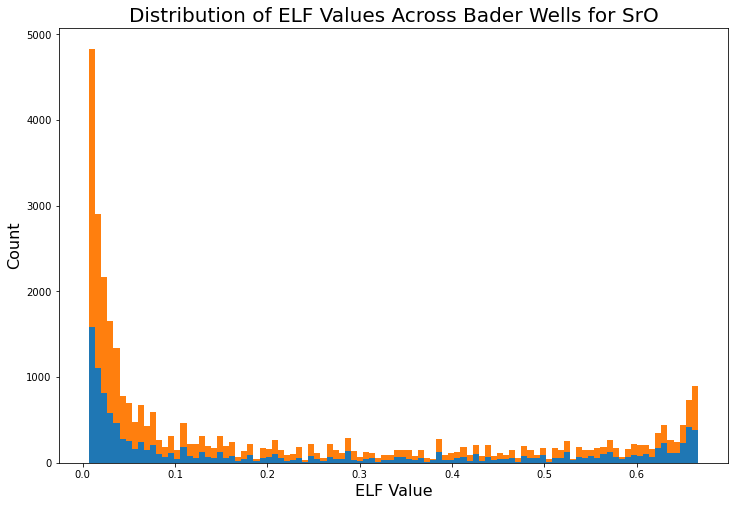

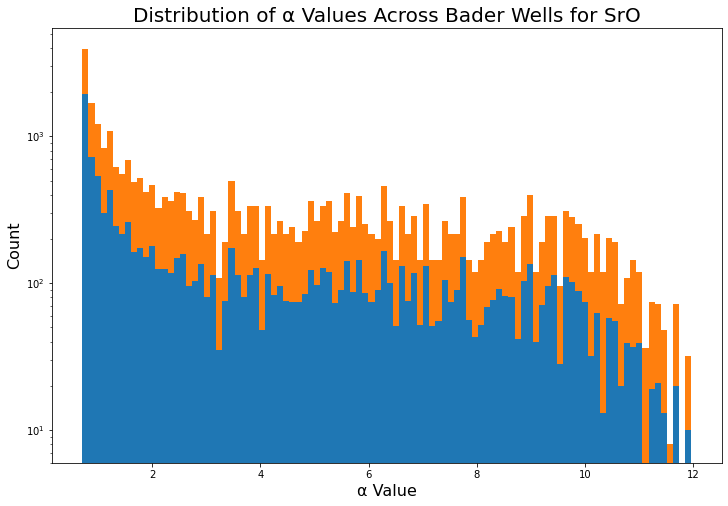

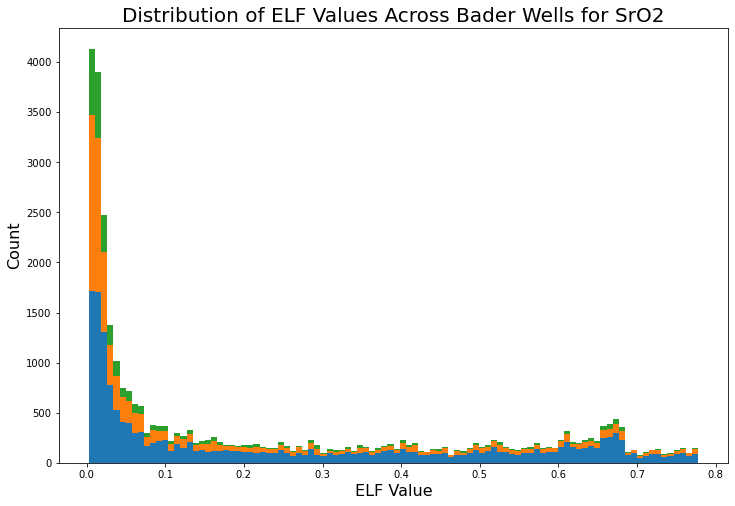

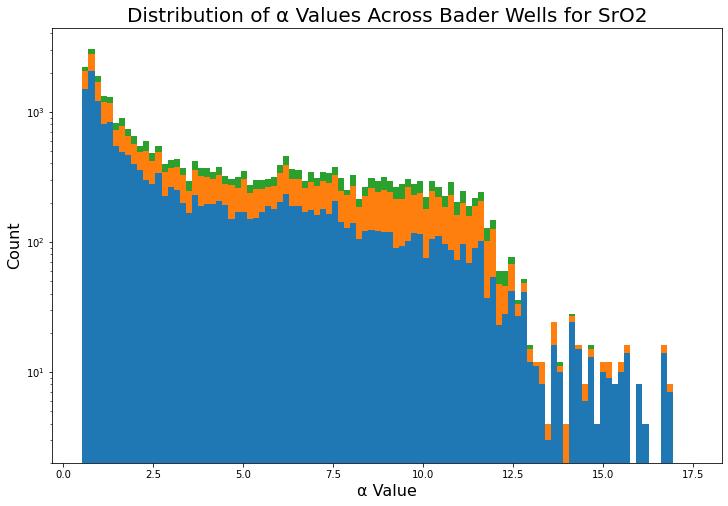

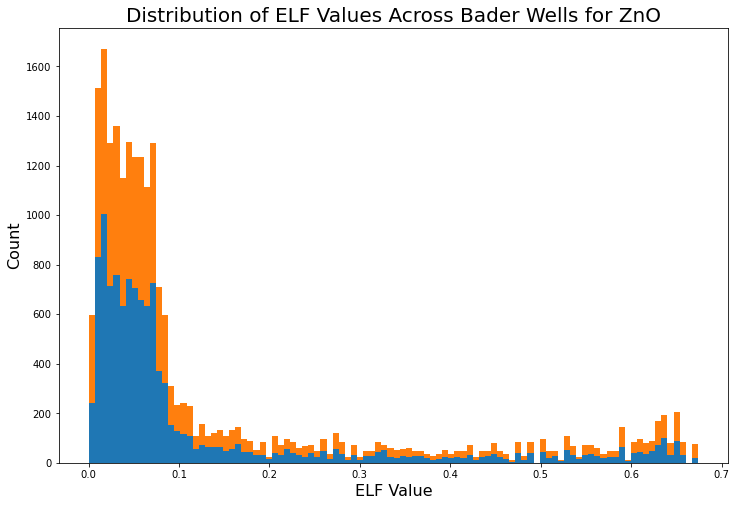

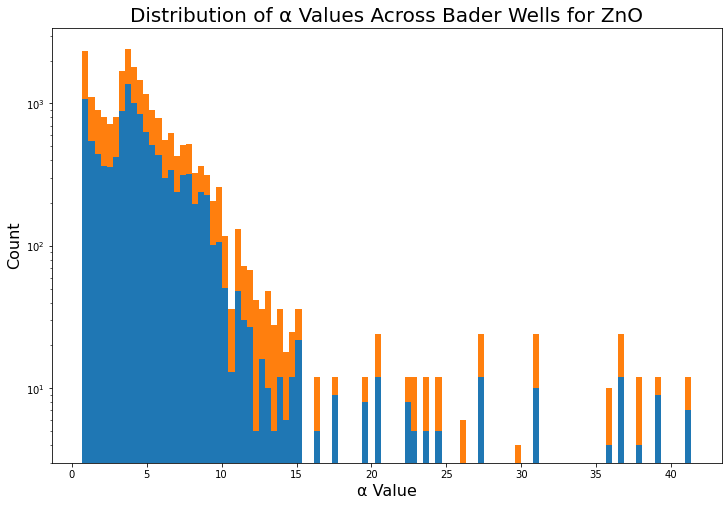

In [102]:
for f in masked_elf.keys():
    plot_histogram(f, mode='elf')
    plot_histogram(f, mode='alpha')